### LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import statsmodels.api as sm
import pylab
import pickle
import warnings

from datetime import datetime
from pandas_dq import dq_report, Fix_DQ
from IPython.display import display, HTML, display_html
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
#from fbprophet import Prophet

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

Imported pandas_dq (1.9). Always upgrade to get latest version.



/var/folders/dk/whmh7n016n59y33jb395nq1c0000gn/T/ipykernel_72902/982045104.py:15: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


### EDA

In [2]:
df = pd.read_excel('linktera_veri_bilimi_veri_seti.xlsx',
  parse_dates=['Date'],
  index_col='Date'
)
# predicted variables are removed
df = df[df.index <'2022-06-01']

display(HTML('<b>Head Data</b>'))
display(df.head())

# look a shape of data
display(HTML('<b>Dataframe Shape</b>'))
display(df.shape)

# look at data types. Ideally look at all rows. 
display(HTML('<b>Data Types</b>'))
display(df.iloc[:,:].dtypes)

# see if any columns have nulls. Ideally look at all rows. 
display(HTML('<b>Nulls</b>'))
display(df.iloc[:,:].isnull().any())


def advdescribe(df):
    stats = df.describe()
    skewness = df.skew()
    kurtosis = df.kurtosis()
   # cv = df.coef_var()
    meanabsoluedeviation = df.mad()
    skewness_df = pd.DataFrame({'skewness': skewness}).T
    kurtosis_df = pd.DataFrame({'kurtosis': skewness}).T
    #cv_df = pd.DataFrame({'cv': cv}).T
    mad_df = pd.DataFrame({'mad': meanabsoluedeviation}).T
    return stats.append([skewness_df, kurtosis_df,mad_df])
advdescribe(df)

,Otomotiv Satis,OTV Orani,Faiz,EUR/TL,Kredi Stok
Date,,,,,
2010-01-01,20095.0000,37.0000,13.1820,2.1074,341244.1260
2010-02-01,31172.0000,37.0000,13.2725,2.0739,351940.9490
2010-03-01,51769.0000,37.0000,12.7275,2.0855,361307.3200
2010-04-01,54946.0000,37.0000,12.0120,2.0090,373575.3400
2010-05-01,59377.0000,37.0000,11.7400,1.9489,387708.0510


(149, 5)

Otomotiv Satis    float64
OTV Orani         float64
Faiz              float64
EUR/TL            float64
Kredi Stok        float64
dtype: object

Otomotiv Satis    False
OTV Orani         False
Faiz              False
EUR/TL            False
Kredi Stok        False
dtype: bool

,Otomotiv Satis,OTV Orani,Faiz,EUR/TL,Kredi Stok
count,149.0000,149.0000,149.0000,149.0000,149.0000
mean,65902.6174,43.6980,16.0344,4.8087,1787554.2949
std,26175.8011,5.8468,5.3195,3.3218,1176365.9706
min,14373.0000,37.0000,9.6075,1.9273,341244.1260
25%,50008.0000,40.0000,12.7150,2.4640,775545.4980
50%,63044.0000,45.0000,14.4850,3.2769,1474594.1210
75%,79819.0000,50.0000,17.4750,6.3806,2447479.1860
max,156173.0000,65.0000,32.7825,16.5600,4862887.4214
skewness,0.9178,0.8376,1.3116,1.7339,0.9018
kurtosis,0.9178,0.8376,1.3116,1.7339,0.9018


In [3]:
profiling = ProfileReport(df)
profiling

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### GRAPHS

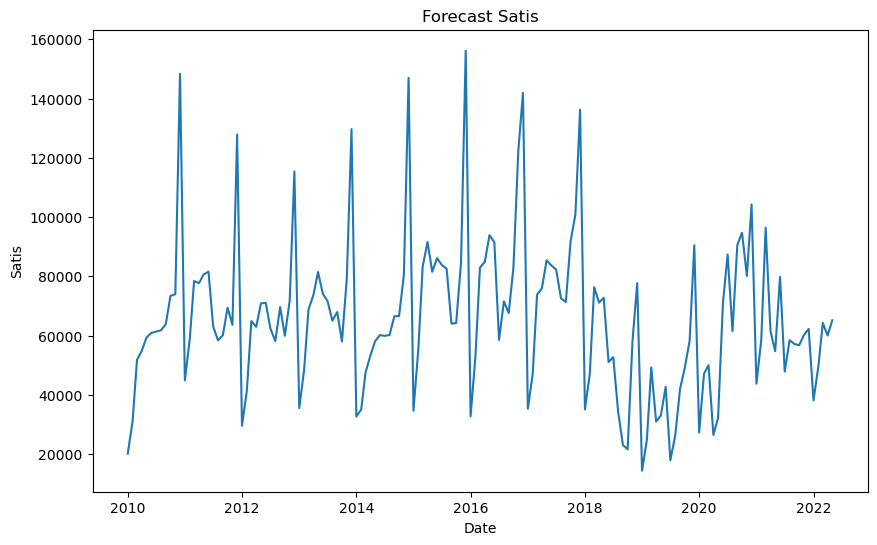

In [4]:
%matplotlib inline

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(df.index, df['Otomotiv Satis'])

# Set the axis labels and title
plt.xlabel('Date')
plt.ylabel('Satis')
plt.title('Forecast Satis')

# Show the plot
plt.show()
# Bağımlı (Hedef) değişkenin belirgi bir tren davranışı yoktur. Fakat seasonality olduğu anlaşılmaktadır.

### Variables

In [5]:
# X = df[['OTV Orani', 'Faiz', 'EUR/TL', 'Kredi Stok']]
# y = df['Otomotiv Satis']

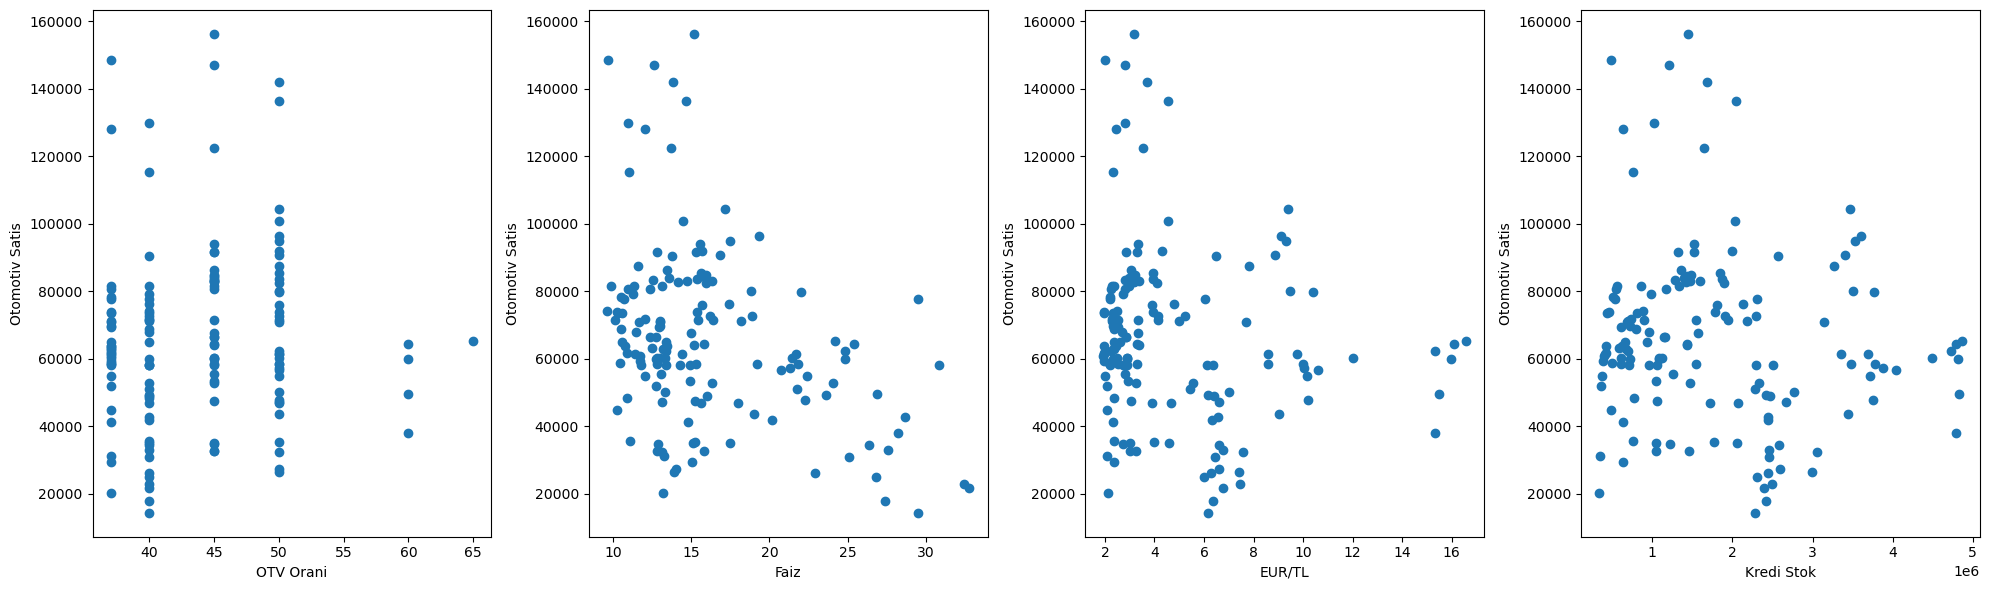

In [6]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.scatter(df['OTV Orani'], df['Otomotiv Satis'])
plt.xlabel('OTV Orani')
plt.ylabel('Otomotiv Satis')
plt.subplot(1, 4, 2)
plt.scatter(df['Faiz'], df['Otomotiv Satis'])
plt.xlabel('Faiz')
plt.ylabel('Otomotiv Satis')
plt.subplot(1, 4, 3)
plt.scatter(df['EUR/TL'], df['Otomotiv Satis'])
plt.xlabel('EUR/TL')
plt.ylabel('Otomotiv Satis')
plt.subplot(1, 4, 4)
plt.scatter(df['Kredi Stok'], df['Otomotiv Satis'])
plt.xlabel('Kredi Stok')
plt.ylabel('Otomotiv Satis')

plt.tight_layout()
plt.show()

# Numerical değişkenlere bakıldığında linear bir davranış göstermediklerini sonucu çıkarılmaktadır.

<AxesSubplot:xlabel='Otomotiv Satis', ylabel='Density'>

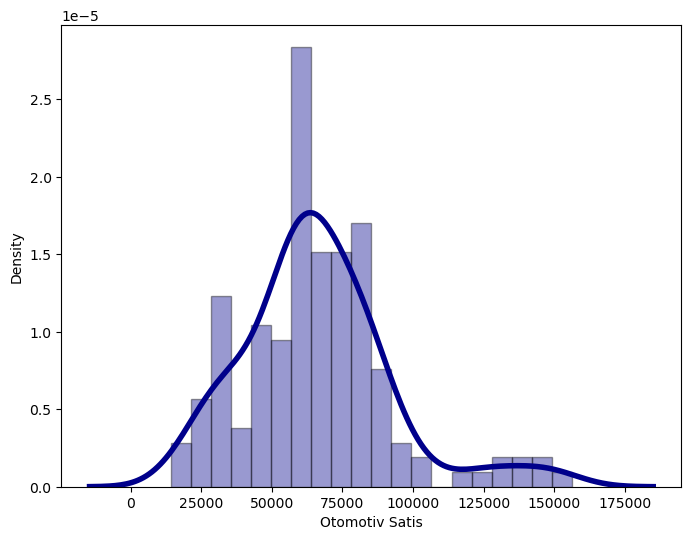

In [7]:
import warnings
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)
#
plt.figure(figsize=(8,6))
sns.distplot(df['Otomotiv Satis'], hist=True, kde=True, 
             bins=int(100/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

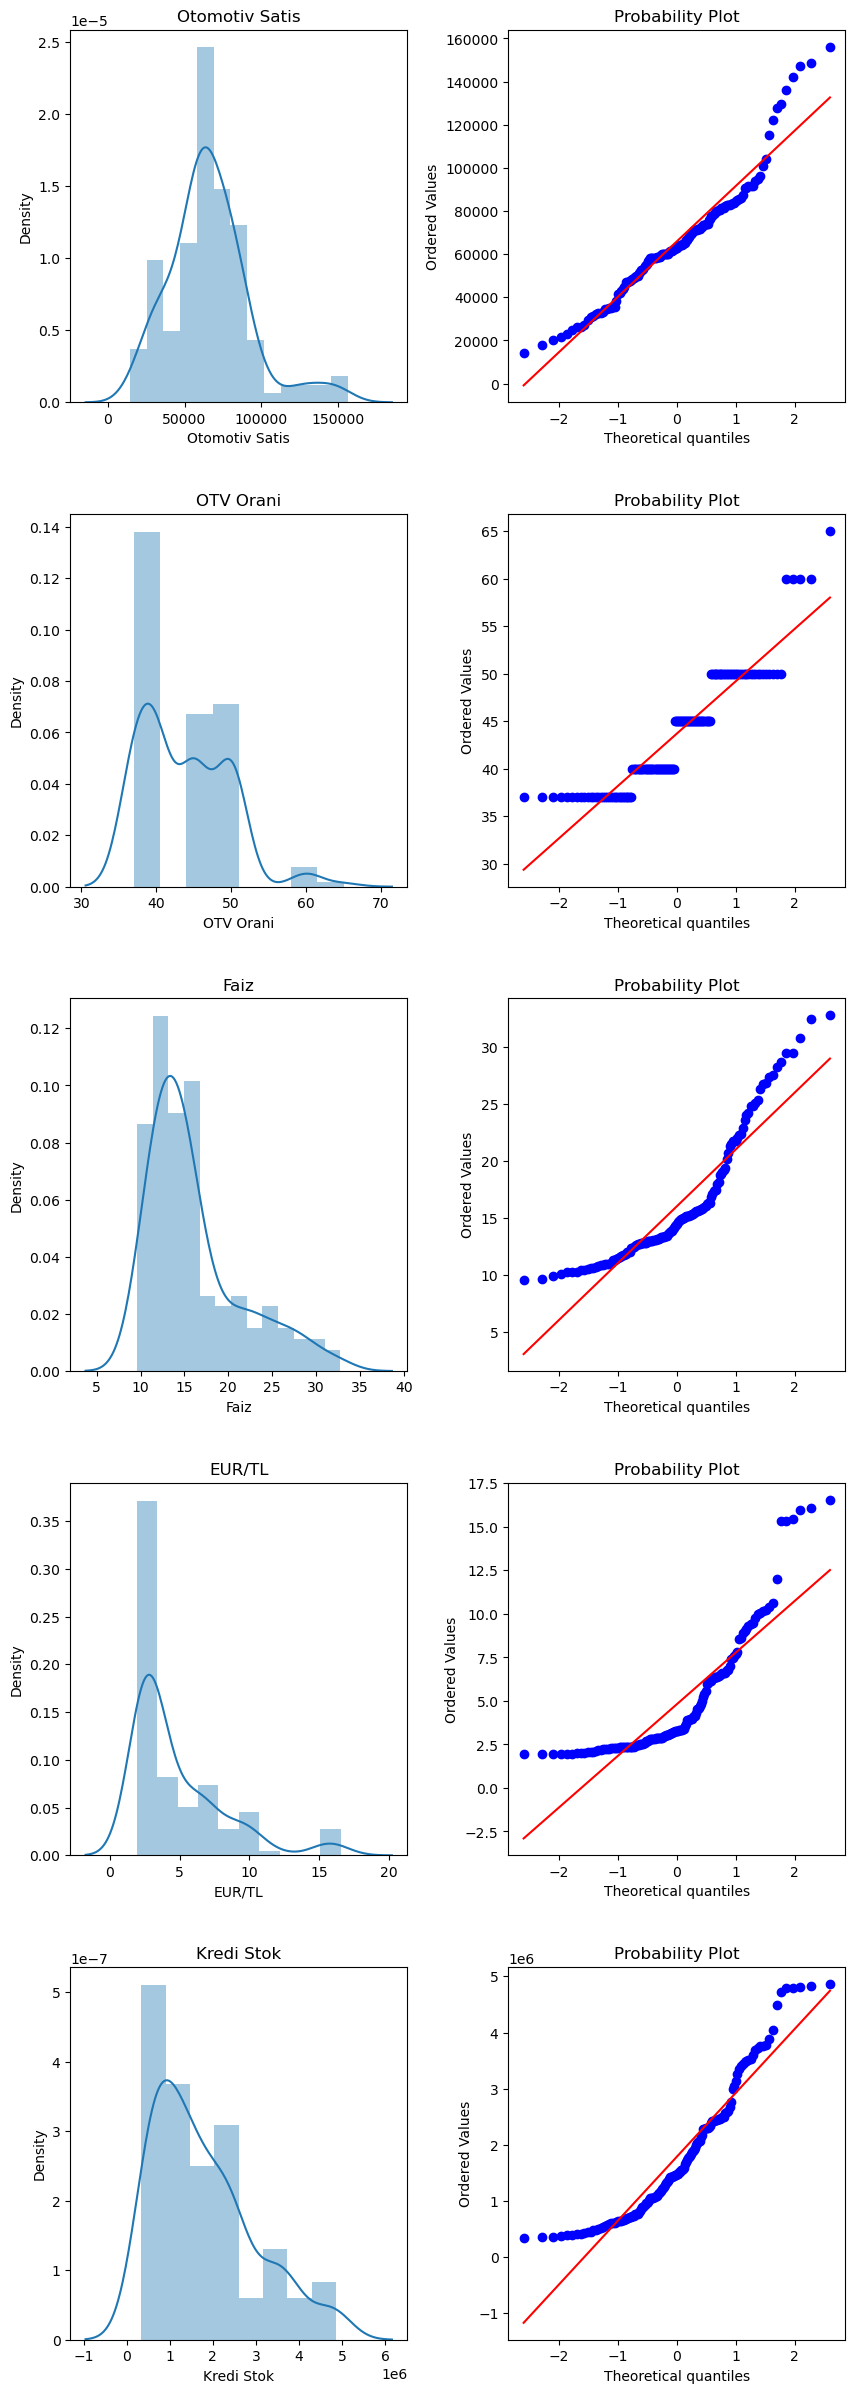

In [8]:
# Transformation of non-linear variables
#create subplot layout
fig = plt.figure(figsize=[10,30]);
grid = plt.GridSpec(5, 2, wspace=0.3, hspace=0.3);

#loop to populate boxplots within subplots
for i, a in enumerate(df.columns):
    exec(f'ax{i}0 = plt.subplot(grid[i,0]);')
    exec(f'sns.distplot(df[a], ax=ax{i}0);')
    exec(f'ax{i}0.set_title(a);')
    exec(f'ax{i}1 = plt.subplot(grid[i,1]);')
    exec(f'stats.probplot(df[a],dist="norm",plot=pylab);')
        
fig.show();

Text(0.5, 1.0, 'Correlation Heatmap')

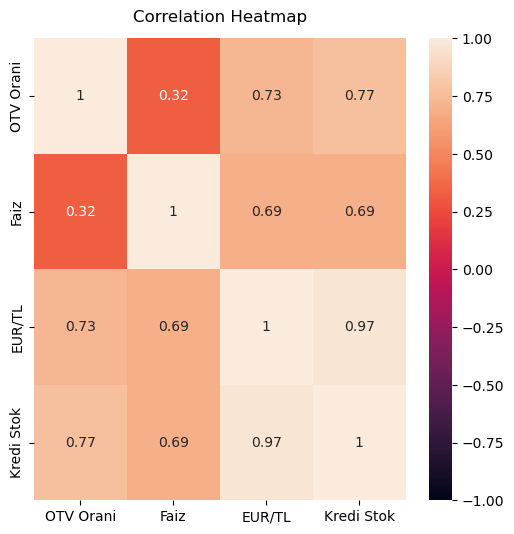

In [10]:
plt.figure(figsize = (6, 6))
heatmap = sns.heatmap(df[['OTV Orani', 'Faiz', 'EUR/TL', 'Kredi Stok']].corr(), vmin = -1, vmax = 1, annot = True)
heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize' : 12}, pad = 12)

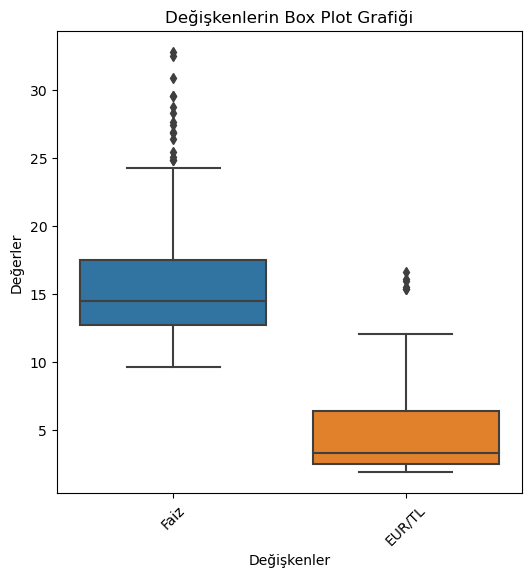

In [12]:
# Box plot grafiklerini çizin
plt.figure(figsize=(6, 6))
sns.boxplot(data=df[['Faiz','EUR/TL']], orient='v')
plt.title('Değişkenlerin Box Plot Grafiği')
plt.xlabel('Değişkenler')
plt.ylabel('Değerler')
plt.xticks(rotation=45)
plt.show()

In [13]:
feature = df[['OTV Orani', 'Faiz', 'EUR/TL', 'Kredi Stok']]

In [14]:
for değişken in feature:
    q1 = df[değişken].quantile(0.15)
    q3 = df[değişken].quantile(0.95)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = (df[değişken] < lower_bound) | (df[değişken] > upper_bound)
    print(f"Outlierlar ({değişken}):")
    print(df[outliers][değişken])
    print()
    df = df[~outliers]

Outlierlar (OTV Orani):
Series([], Name: OTV Orani, dtype: float64)

Outlierlar (Faiz):
Series([], Name: Faiz, dtype: float64)

Outlierlar (EUR/TL):
Series([], Name: EUR/TL, dtype: float64)

Outlierlar (Kredi Stok):
Series([], Name: Kredi Stok, dtype: float64)



In [15]:
df_dist = df.copy()
df_drop = df.copy()

In [16]:
df

,Otomotiv Satis,OTV Orani,Faiz,EUR/TL,Kredi Stok
Date,,,,,
2010-01-01,20095.0000,37.0000,13.1820,2.1074,341244.1260
2010-02-01,31172.0000,37.0000,13.2725,2.0739,351940.9490
2010-03-01,51769.0000,37.0000,12.7275,2.0855,361307.3200
2010-04-01,54946.0000,37.0000,12.0120,2.0090,373575.3400
2010-05-01,59377.0000,37.0000,11.7400,1.9489,387708.0510
...,...,...,...,...,...
2022-01-01,38131.0000,60.0000,28.2500,15.3424,4794119.7590
2022-02-01,49652.0000,60.0000,26.8525,15.4700,4822579.1610
2022-03-01,64267.0000,60.0000,25.3950,16.0800,4791176.3893


Text(0.5, 1.0, 'OTV')

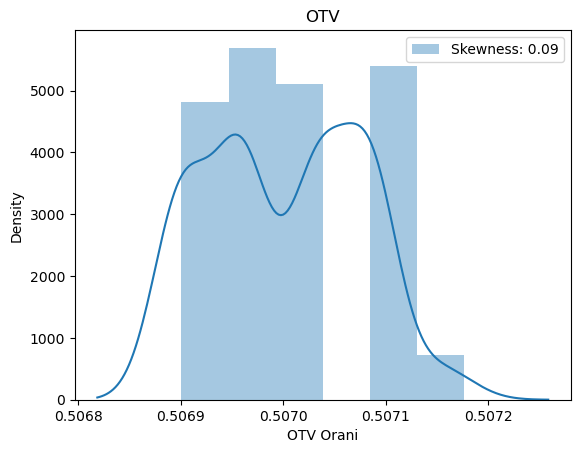

In [17]:
transformed_data, lambda_ = stats.boxcox(df_dist['OTV Orani'])
df_dist['OTV Orani'] = transformed_data

sns.distplot(df_dist['OTV Orani'], label = 'Skewness: %.2f'%(df_dist['OTV Orani'].skew()))
plt.legend(loc = 'best')
plt.title('OTV')

Text(0.5, 1.0, 'Kredi')

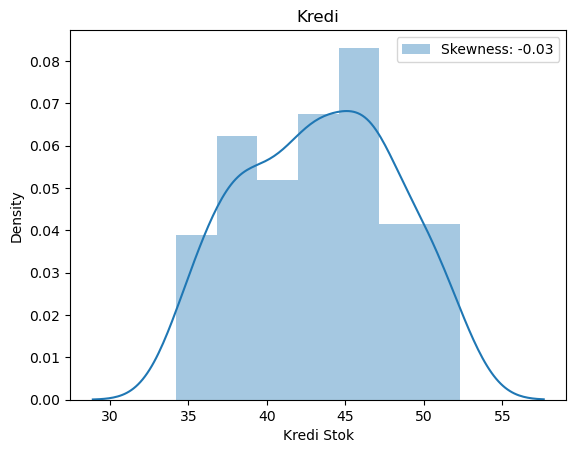

In [18]:
transformed_data, lambda_ = stats.boxcox(df_dist['Kredi Stok'])
df_dist['Kredi Stok'] = transformed_data

sns.distplot(df_dist['Kredi Stok'], label = 'Skewness: %.2f'%(df_dist['Kredi Stok'].skew()))
plt.legend(loc = 'best')
plt.title('Kredi')

Text(0.5, 1.0, 'Faiz')

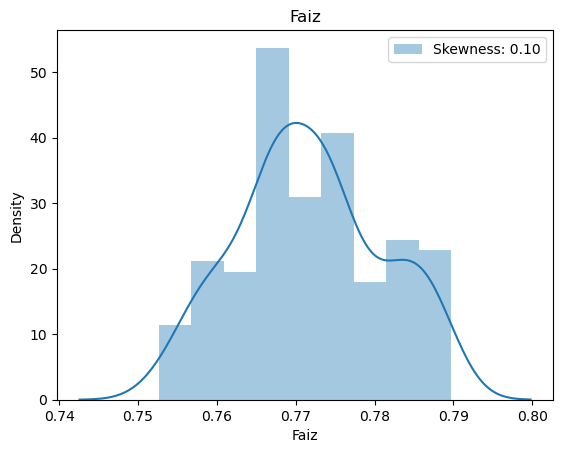

In [19]:
transformed_data, lambda_ = stats.boxcox(df_dist['Faiz'])
df_dist['Faiz'] = transformed_data

sns.distplot(df_dist['Faiz'], label = 'Skewness: %.2f'%(df_dist['Faiz'].skew()))
plt.legend(loc = 'best')
plt.title('Faiz')

Text(0.5, 1.0, 'Money')

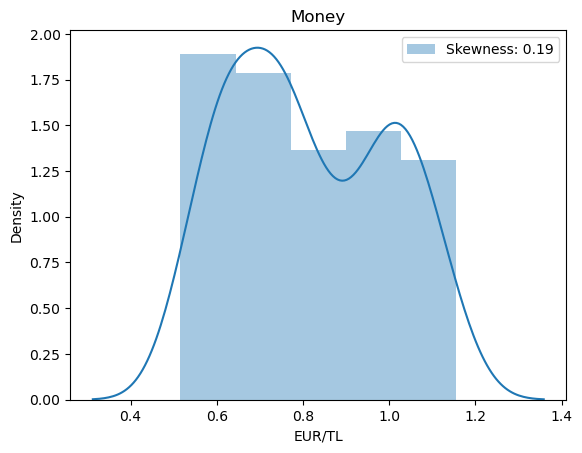

In [20]:
transformed_data, lambda_ = stats.boxcox(df_dist['EUR/TL'])
df_dist['EUR/TL'] = transformed_data

sns.distplot(df_dist['EUR/TL'], label = 'Skewness: %.2f'%(df_dist['EUR/TL'].skew()))
plt.legend(loc = 'best')
plt.title('Money')

In [21]:
X_dist = df_dist[['OTV Orani', 'Faiz', 'EUR/TL', 'Kredi Stok']]
y_dist = df_dist['Otomotiv Satis']

### Multicolinearity detection with Model

In [22]:
#X = X.drop(columns = 'const', inplace =True)
X_train, X_test, y_train, y_test = train_test_split(X_dist, y_dist, test_size = 0.2, random_state = 27, shuffle = True)

In [23]:
X_dist = sm.add_constant(X_dist)
model = sm.OLS(y_train, X_train)
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:         Otomotiv Satis   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.893
Method:                 Least Squares   F-statistic:                              248.1
Date:                Wed, 17 May 2023   Prob (F-statistic):                    1.45e-55
Time:                        11:06:40   Log-Likelihood:                         -1363.8
No. Observations:                 119   AIC:                                      2736.
Df Residuals:                     115   BIC:                                      2747.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [24]:
y_pred = res.predict(X_test)

### When Multicolinearity Drop Kredi Stok Model

In [26]:
X_new = df_dist[['OTV Orani','Faiz','EUR/TL']]
y_new = df_dist['Otomotiv Satis']

In [27]:
#X = X.drop(columns = 'const', inplace =True)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2, random_state = 27, shuffle = True)

In [28]:
X_new = sm.add_constant(X_new)
model_new = sm.OLS(y_train_new, X_train_new)
res_new = model_new.fit()
print(res_new.summary())

                                 OLS Regression Results                                
Dep. Variable:         Otomotiv Satis   R-squared (uncentered):                   0.882
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                              289.7
Date:                Wed, 17 May 2023   Prob (F-statistic):                    1.07e-53
Time:                        11:06:40   Log-Likelihood:                         -1371.3
No. Observations:                 119   AIC:                                      2749.
Df Residuals:                     116   BIC:                                      2757.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [29]:
y_pred2 = res_new.predict(X_test_new)
y_pred2

Date
2019-09-01   57643.9852
2013-01-01   77040.8047
2020-09-01   68696.3953
2019-10-01   67892.4138
2017-05-01   63820.4849
2016-03-01   58269.9152
2017-08-01   62618.7423
2019-08-01   53187.8147
2016-06-01   61984.2823
2011-10-01   66631.0667
2017-11-01   69874.8936
2021-02-01   62565.7414
2013-12-01   81129.8203
2017-07-01   63201.9394
2014-11-01   72171.0684
2015-10-01   60344.8697
2010-10-01   76480.7532
2020-01-01   75699.7559
2022-04-01   57821.8445
2018-10-01   44549.8725
2015-06-01   68162.6811
2011-01-01   80390.2321
2014-08-01   70233.9855
2011-09-01   66260.5232
2022-01-01   54137.6023
2018-11-01   44902.3506
2017-09-01   62146.8051
2014-02-01   61342.4444
2020-10-01   67317.4662
2020-03-01   79436.0135
dtype: float64

In [31]:
# Denemeler sonucunda Kredi stok değerinin çıkmasının R2 adjusted değerini azalttığı görülmektedir. 
# Bu şekilde dağılımların normale yakınlaştırılıp Kredi stok değerinin çıkarılmadan devam edilmesi sonucuna varılmaktadır.

In [32]:
with open('res_new.pkl', 'wb') as file:
    pickle.dump(res_new, file)